In [ ]:
# Comparing my tensorflow implementation of the linear conjugate gradient method to the scipy.
# Since my implementation assumes float32 arrays, the accuracy of the results is going to be quite a bit lower.
# however, the output should be

In [2]:
import numpy as np
from scipy.sparse import linalg
import tensorflow as tf
from sopt.optimizers.tensorflow.utils import MatrixFreeLinearOp, conjugate_gradient
import matplotlib.pyplot as plt

In [3]:
# Creating a linear system.

In [4]:
m = np.random.randn(20, 20)

A = m @ m.T

In [5]:
# Ensuring the matrix is symmetric and positive definite. All eigvals should be positive
np.linalg.eigvals(A)

array([5.91334514e+01, 4.92110216e+01, 3.99611533e+01, 3.45376174e+01,
       3.23181988e+01, 2.42207034e+01, 2.17553577e+01, 1.69006128e+01,
       1.37958778e+01, 9.80994641e+00, 9.08417418e+00, 7.59292889e+00,
       6.16346664e+00, 3.17523812e+00, 2.32691485e+00, 1.59224717e+00,
       3.48651608e-03, 2.23039432e-01, 9.38569114e-01, 7.40838434e-01])

In [6]:
A_precond = np.linalg.inv(A * 5 + 1)

In [7]:
x_true = np.random.randn(20)
y = (A @ x_true[:,None]).reshape(-1)
x0 = np.random.randn(20)

In [8]:
# Results using scipy
def getScipyErrors(maxiter):
    x_pred = linalg.cg(A, y, maxiter=maxiter, x0=x0)[0]
    pcg_x_pred = linalg.cg(A, y, maxiter=maxiter, M=A_precond, x0=x0)[0]
    errors = x_pred - x_true
    errors_pcg = pcg_x_pred - x_true
    return np.sum(errors**2), np.sum(errors_pcg**2)

In [9]:
# Using my conjugate gradient method

In [10]:
tf.reset_default_graph()

In [11]:
A_t = tf.constant(A, dtype='float32')
A_precond_t = tf.constant(A_precond, dtype='float32')
y_t = tf.constant(y, dtype='float32')
x_true_t = tf.constant(x_true, dtype='float32')
x0_t = tf.constant(x0, dtype='float32')

In [12]:
matvec = lambda x: tf.reshape(A_t @ x[:, None], [-1])

In [13]:
linop = MatrixFreeLinearOp(operator=matvec, shape=y_t.get_shape())

In [14]:
precond_matvec = lambda x: tf.reshape(A_precond_t @ x[:, None], [-1])
precond_linop = MatrixFreeLinearOp(operator=precond_matvec, shape=y_t.get_shape())

In [15]:
maxiter = tf.placeholder(tf.int32, shape=[])
x_pred_t = conjugate_gradient(linop, y_t, tol=1e-6, max_iter=maxiter, x=x0_t)
errors_t = x_pred_t.x - x_true_t
lsq_errors_t = tf.reduce_sum(errors_t**2)

In [16]:
pcg_x_pred_t = conjugate_gradient(linop, y_t, tol=1e-6, max_iter=maxiter, preconditioner=precond_linop, x=x0_t)
pcg_errors_t = pcg_x_pred_t.x - x_true_t
pcg_lsq_errors_t = tf.reduce_sum(pcg_errors_t**2)

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [18]:
lsq_errors_scipy = []
lsq_errors_pcg_scipy = []
lsq_errors_tf = []
lsq_errors_pcg_tf = []
for i in range(1,50):
    se1, se2 = getScipyErrors(i)
    lsq_errors_scipy.append(se1)
    lsq_errors_pcg_scipy.append(se2)
    e1, e2 = sess.run([lsq_errors_t, pcg_lsq_errors_t], feed_dict={maxiter:i})
    lsq_errors_tf.append(e1)
    lsq_errors_pcg_tf.append(e2)

In [22]:
sess.run(pcg_x_pred_t, feed_dict={maxiter:2})

CGState(i=2, x=array([ 0.89555   , -1.1711347 ,  1.0844897 ,  0.20900443,  0.06882337,
        1.1495142 ,  0.2549181 , -0.24491906,  1.7467738 , -0.06774941,
       -1.1341972 ,  0.8200023 ,  0.14578445, -0.89128417,  1.2413588 ,
       -0.3120194 , -0.2895892 ,  1.9303468 ,  0.08984564, -0.24353632],
      dtype=float32), r=array([-0.00134233, -0.00541121, -0.00576572,  0.00515923, -0.00470891,
       -0.00152343, -0.0035232 , -0.01250515,  0.00458801,  0.00140582,
       -0.01142921, -0.00327327, -0.00290361, -0.00017695, -0.00540475,
       -0.00301073,  0.00490722,  0.00040232, -0.00267526, -0.0014395 ],
      dtype=float32), p=array([-9.3750416e-05, -1.4546918e-04,  2.3346936e-04, -2.9718372e-05,
       -2.8330961e-04,  7.7095414e-05, -2.1225525e-05, -3.8679829e-04,
       -1.2960237e-04, -1.0597952e-04,  1.5269817e-04, -2.2388774e-04,
       -2.0887765e-04,  1.2537552e-04,  1.6556986e-04, -2.1530970e-05,
       -3.5012919e-05, -1.2900705e-04,  6.8011534e-05, -6.8898968e-05],
   

In [23]:
 linalg.cg(A, y, maxiter=2, M=A_precond, x0=x0)

(array([ 0.89505555, -1.17188686,  1.08575223,  0.20885108,  0.06731419,
         1.14992458,  0.25480018, -0.24695197,  1.74607555, -0.06830677,
        -1.13336571,  0.8188121 ,  0.144662  , -0.89061604,  1.24226667,
        -0.3121334 , -0.289776  ,  1.929665  ,  0.09022263, -0.24391601]),
 0)

In [151]:
A_precond @ x0

array([-0.88576584,  0.02956672,  0.3995625 ,  0.05235155,  0.30806722,
       -0.32455984,  0.07704874,  0.2130691 , -0.17643215,  0.02576647,
        0.13246974, -0.35094607,  0.39992595, -0.16832022,  0.05209812,
       -0.94169653,  0.28960878,  0.01115067,  0.19486158, -0.20790812])

In [147]:
# The tensorflow results are less accurate after a point.

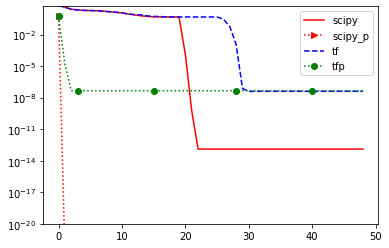

In [40]:
plt.plot(lsq_errors_scipy, color='red', label='scipy')
plt.plot(lsq_errors_pcg_scipy, color='red', ls=":", label='scipy_p', markevery=0.2, marker='>')
plt.plot(lsq_errors_tf, color='blue', ls='--', label='tf')
plt.plot(lsq_errors_pcg_tf, color='green', ls=':', label='tfp', markevery=0.2, marker='o')
plt.legend(loc='best')
plt.yscale('log')
plt.ylim([1e-20, 5])
#plt.yscale('log')
plt.show()